This notebook compares two kernel-based regression methods [Vector Regression vs Regularization Network] on the non-linear `function_a` dataset:

### *Dataset* (`function_a`)
- 1000 points : large dataset to proove the **difference of computation time**

### *Regressions*
1. Support Vector Regression (SVR)
- Relies on the **ε-insensitive loss**: ignores errors smaller than ε = 1.5
- **Sparse solution**: only support vectors contribute to the model
- Optimization: **Quadratic Programming** (QP)

2. Regularization Network (Kernel Ridge Regression)
- Uses **quadratic loss**: penalizes all errors
- **Dense solution**: all training points contribute to the model
- Optimization: Solving a **linear system** $(K + \lambda I) c = y$

### *Key differences to observe:*
- Sparsity: SVR uses subset of points vs. Regularization Network uses all points
- Fitting behavior: ε-tube vs. minimizing squared error
- Speed : SVR must be faster than RN

In [40]:
%load_ext autoreload
%autoreload 2

# Third party libraries imports
import numpy as np
import matplotlib.pyplot as plt
import time

# Local imports
from sv_machines.datasets.function_a import get_function_a_dataset, get_function_a_plot, function_a
from sv_machines.datasets.utils import add_prediction_function_to_plot

# Scikit-learn imports
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load a `function_a` dataset

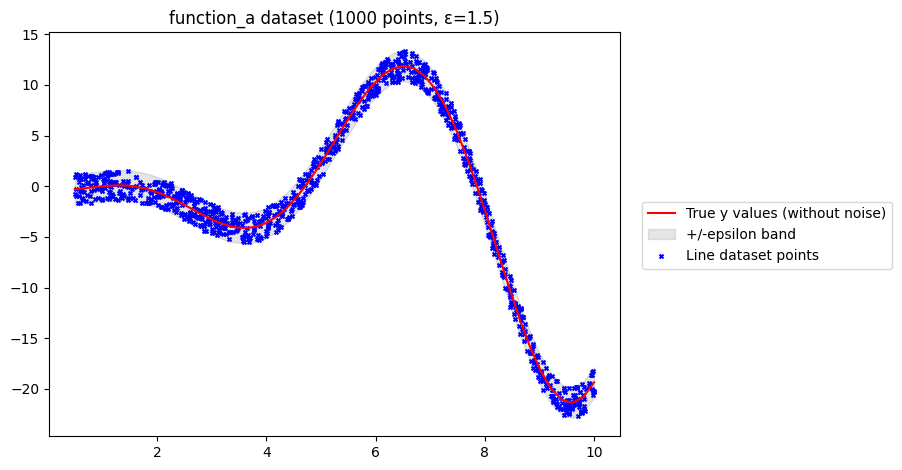

In [51]:
# Dataset
epsilon = 1.5
num_points = 1000  # Large dataset to visualize support vectors and compare computation time

x_data, y_data = get_function_a_dataset(
    epsilon=epsilon, num_points=num_points, epsilon_strict=True
)

# Plot
fig, ax = get_function_a_plot(x_data, y_data, epsilon, with_true_function=True)
ax.set_title(f"function_a dataset ({num_points} points, ε={epsilon})")
fig.tight_layout()
fig.legend(loc="center left", bbox_to_anchor=(1, 0.5));


# Reshape for sklearn
X_train = x_data.reshape(-1, 1)
y_train = y_data





# 1. Perfom $\varepsilon$ "soft" support vector regression on the dataset
Using a RBF kernel of parameter $\gamma$ = 0.5, SVR minimizes:
$$\min_{\mathbf{w}, b, \boldsymbol{\xi}, \boldsymbol{\xi}^*} \frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^{n} (\xi_i + \xi_i^*)$$


###  SVR set up and training :


In [52]:
C_svr = 100  
epsilon_svr = epsilon
gamma_svr = 0.5

svr_model = SVR(kernel='rbf', C=C_svr, epsilon=epsilon_svr, gamma=gamma_svr)

start_time = time.perf_counter()
svr_model.fit(X_train, y_train)
svr_training_time = time.perf_counter() - start_time

support_vectors_idx = svr_model.support_
n_support_vectors = len(support_vectors_idx)

print("SVR Set up:")
print(f"  - Training time: {svr_training_time*1000:.3f} ms")
print(f"  - Number of support vectors: {n_support_vectors} / {num_points} ({100*n_support_vectors/num_points:.1f}%)")
print(f"  - Parameters: C={C_svr}, ε={epsilon_svr}, γ={gamma_svr}")

SVR Set up:
  - Training time: 26.811 ms
  - Number of support vectors: 15 / 1000 (1.5%)
  - Parameters: C=100, ε=1.5, γ=0.5


###  Plot SVR results with support vectors highlighted :

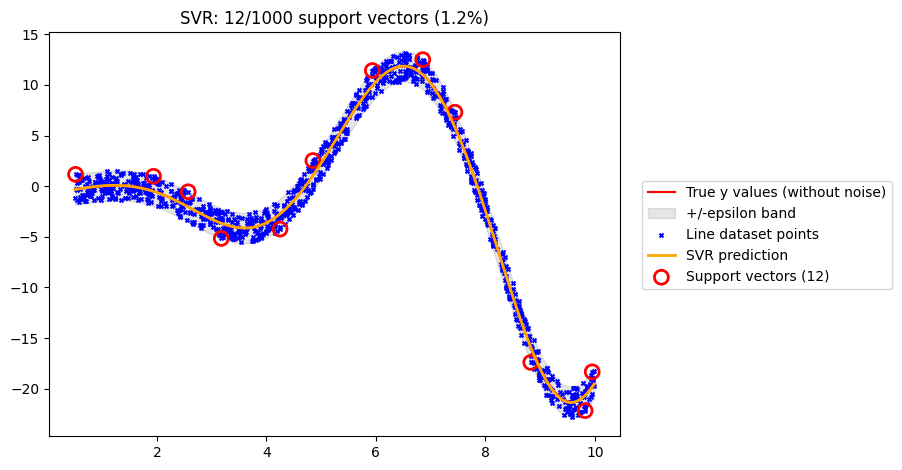

In [43]:
fig, ax = get_function_a_plot(x_data, y_data, epsilon, with_true_function=True)

# Predicted regression function
x_plot = np.linspace(min(x_data), max(x_data), 200).reshape(-1, 1)
y_svr_pred = svr_model.predict(x_plot)
ax.plot(x_plot, y_svr_pred, color='orange', linewidth=2, label='SVR prediction')

# Add support vectors
ax.scatter(
    X_train[support_vectors_idx], 
    y_train[support_vectors_idx], 
    s=100, facecolors='none', edgecolors='red', linewidths=2,
    label=f'Support vectors ({n_support_vectors})'
)

ax.set_title(f"SVR: {n_support_vectors}/{num_points} support vectors ({100*n_support_vectors/num_points:.1f}%)")
fig.tight_layout()
fig.legend(loc="center left", bbox_to_anchor=(1, 0.5));


# 2. Regularization Network (Kernel Ridge Regression)

The Regularization Network minimizes:
$$\min_{\mathbf{c}} \sum_{i=1}^{n} (y_i - f(x_i))^2 + \lambda \|\mathbf{c}\|^2_K$$

Where $f(x) = \sum_{j=1}^n c_j K(x, x_j)$ with $K$ being the kernel function.

The solution is obtained by solving the **linear system**:
$$(K + \lambda I) \mathbf{c} = \mathbf{y}$$



In [62]:
# Regularization Network parameters
alpha_krr = 0.1
gamma_krr = gamma_svr  # Same kernel parameter as SVR

krr_model = KernelRidge(kernel='rbf', alpha=alpha_krr, gamma=gamma_krr)

start_time = time.perf_counter()
krr_model.fit(X_train, y_train)
krr_training_time = time.perf_counter() - start_time

print("Regularization Network (Kernel Ridge) Set up:")
print(f"  - Training time: {krr_training_time*1000:.3f} ms")
print(f"  - Number of points used: {num_points} / {num_points} (100.0%) - ALL points contribute")
print(f"  - Parameters: α={alpha_krr}, γ={gamma_krr}")


Regularization Network (Kernel Ridge) Set up:
  - Training time: 43.287 ms
  - Number of points used: 1000 / 1000 (100.0%) - ALL points contribute
  - Parameters: α=0.1, γ=0.5


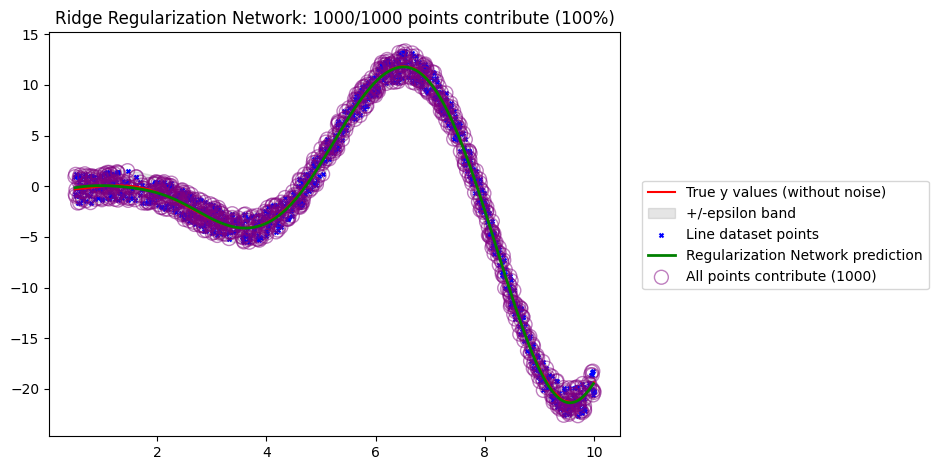

In [65]:
fig, ax = get_function_a_plot(x_data, y_data, epsilon, with_true_function=True)

# Prediction dunction
y_krr_pred = krr_model.predict(x_plot)
ax.plot(x_plot, y_krr_pred, color='green', linewidth=2, label='Regularization Network prediction')

# ALL points are contributors (no sparsity)
ax.scatter(
    X_train, y_train, 
    s=100, facecolors='none', edgecolors='purple', linewidths=1, alpha=0.5,
    label=f'All points contribute ({num_points})'
)

ax.set_title(f"Ridge Regularization Network: {num_points}/{num_points} points contribute (100%)")
fig.tight_layout()
fig.legend(loc="center left", bbox_to_anchor=(1, 0.5));


## 3. Side-by-Side Comparison


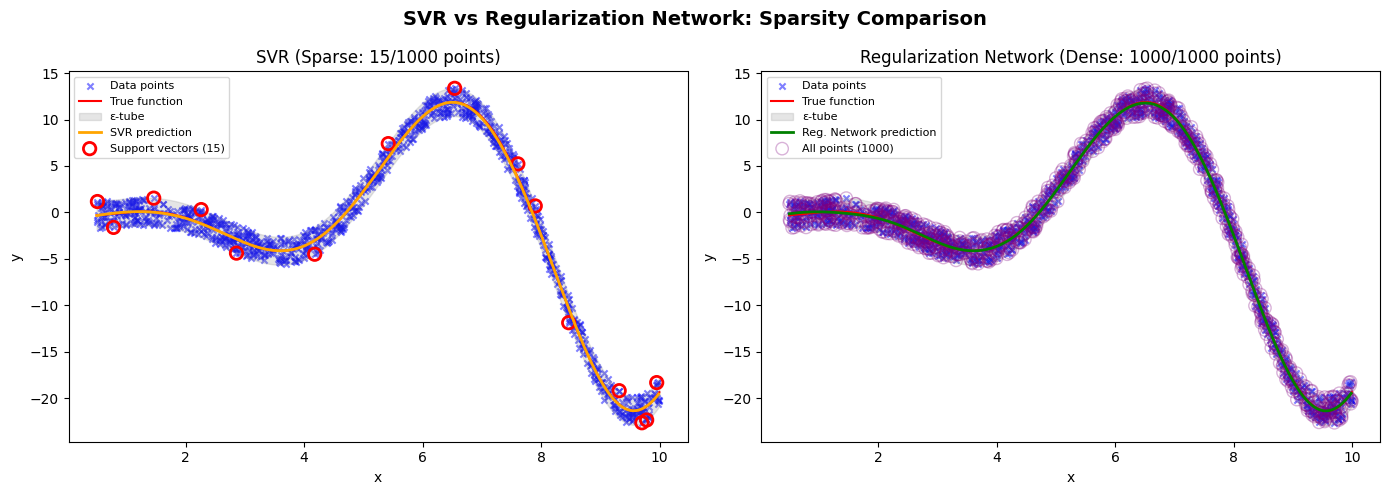

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reference
x_true = np.linspace(min(x_data), max(x_data), 200)
y_true = function_a(x_true)

# Left plot: SVR
ax = axes[0]
ax.scatter(x_data, y_data, marker='x', s=20, color='blue', alpha=0.5, label='Data points')
ax.plot(x_true, y_true, 'r-', linewidth=1.5, label='True function')
ax.fill_between(x_true, y_true - epsilon, y_true + epsilon, color='gray', alpha=0.2, label='ε-tube')
ax.plot(x_plot, y_svr_pred, 'orange', linewidth=2, label='SVR prediction')
ax.scatter(X_train[support_vectors_idx], y_train[support_vectors_idx], 
           s=80, facecolors='none', edgecolors='red', linewidths=2, label=f'Support vectors ({n_support_vectors})')
ax.set_title(f"SVR (Sparse: {n_support_vectors}/{num_points} points)")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='upper left', fontsize=8)

# Right plot: Ridge Regularization Network
ax = axes[1]
ax.scatter(x_data, y_data, marker='x', s=20, color='blue', alpha=0.5, label='Data points')
ax.plot(x_true, y_true, 'r-', linewidth=1.5, label='True function')
ax.fill_between(x_true, y_true - epsilon, y_true + epsilon, color='gray', alpha=0.2, label='ε-tube')
ax.plot(x_plot, y_krr_pred, 'green', linewidth=2, label='Reg. Network prediction')
ax.scatter(X_train, y_train, s=80, facecolors='none', edgecolors='purple', linewidths=1, alpha=0.3, 
           label=f'All points ({num_points})')
ax.set_title(f"Regularization Network (Dense: {num_points}/{num_points} points)")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='upper left', fontsize=8)

fig.suptitle("SVR vs Regularization Network: Sparsity Comparison", fontsize=14, fontweight='bold')
fig.tight_layout()


## 4. Quantitative Comparison
### MSE and MAE of the two trained models versus the true values


In [67]:
# Compute prediction errors
y_true_train = function_a(x_data)  # True function values (without noise)

# SVR
svr_pred_train = svr_model.predict(X_train)
svr_mse = np.mean((svr_pred_train - y_true_train)**2)
svr_mae = np.mean(np.abs(svr_pred_train - y_true_train))

# Ridge Regularization Network 
krr_pred_train = krr_model.predict(X_train)
krr_mse = np.mean((krr_pred_train - y_true_train)**2)
krr_mae = np.mean(np.abs(krr_pred_train - y_true_train))

# Print comparison table
print("=" * 60)
print("COMPARISON: SVR vs Regularization Network")
print("=" * 60)
print(f"\n{'Metric':<30} {'SVR':<15} {'Reg. Network':<15}")
print("-" * 60)
print(f"{'Training time (ms)':<30} {svr_training_time*1000:<15.3f} {krr_training_time*1000:<15.3f}")
print(f"{'Points used':<30} {n_support_vectors:<15} {num_points:<15}")
print(f"{'Sparsity (%)':<30} {100*(1-n_support_vectors/num_points):.1f}%{'':<10} {'0.0%':<15}")
print(f"{'MSE (vs true function)':<30} {svr_mse:<15.4f} {krr_mse:<15.4f}")
print(f"{'MAE (vs true function)':<30} {svr_mae:<15.4f} {krr_mae:<15.4f}")
print("=" * 60)


COMPARISON: SVR vs Regularization Network

Metric                         SVR             Reg. Network   
------------------------------------------------------------
Training time (ms)             26.811          43.287         
Points used                    15              1000           
Sparsity (%)                   98.5%           0.0%           
MSE (vs true function)         0.0008          0.0057         
MAE (vs true function)         0.0220          0.0637         
